In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('netflix.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'netflix.txt'

In [ ]:
df.head()

In [ ]:
df.shape

(8807, 12)

In [ ]:
df.columns.to_list()

['show_id',
 'type',
 'title',
 'director',
 'cast',
 'country',
 'date_added',
 'release_year',
 'rating',
 'duration',
 'listed_in',
 'description']

In [ ]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'year_added', 'month_added', 'month_name_added', 'duration_int',
       'duration_type'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
show_id,8807,8807,s8807,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,8807,2,Movie,6131,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,8807,8807,Zubaan,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,6173,4528,Rajiv Chilaka,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cast,7982,7692,David Attenborough,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,7976,748,United States,2818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_added,8797,1767,"January 1, 2020",109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_year,8807.0,NaN,NaN,NaN,2014.180198,8.819312,1925.0,2013.0,2017.0,2019.0,2021.0
rating,8803,17,TV-MA,3207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,8804,220,1 Season,1793,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Parse date_added (many rows may be NaN)
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# derive year_added, month_added, day_added
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df['month_name_added'] = df['date_added'].dt.month_name()

# release_year already exists; ensure int
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce').astype('Int64')

# duration: split minutes vs seasons
def parse_duration(x):
    if pd.isna(x):
        return np.nan, np.nan
    if 'min' in x:
        return int(x.strip().split(' ')[0]),  'minutes'
    if 'Season' in x or 'Seasons' in x:
        return int(x.strip().split(' ')[0]), 'seasons'
    return np.nan, np.nan

df[['duration_int','duration_type']] = df['duration'].apply(lambda r: pd.Series(parse_duration(r)))
df['duration_int'] = pd.to_numeric(df['duration_int'], errors='coerce').astype('Float64')

# convert some columns to category dtype for efficiency
for c in ['type','rating','duration_type']:
    if c in df.columns:
        df[c] = df[c].astype('category')


In [ ]:
# helper to split by comma and strip
def split_strip(s):
    if pd.isna(s): return []
    return [x.strip() for x in s.split(',') if x.strip()!='']

# create exploded frames (example: countries)
df_country = df[['show_id','title','type','country']].copy()
df_country['country_list'] = df_country['country'].apply(split_strip)
df_country_expl = df_country.explode('country_list').rename(columns={'country_list':'country_exploded'})

# same for cast and directors and genres
df_cast = df[['show_id','title','type','cast']].copy()
df_cast['cast_list'] = df_cast['cast'].apply(split_strip)
df_cast_expl = df_cast.explode('cast_list').rename(columns={'cast_list':'actor'})

df_dir = df[['show_id','title','type','director']].copy()
df_dir['director_list'] = df_dir['director'].apply(split_strip)
df_dir_expl = df_dir.explode('director_list').rename(columns={'director_list':'director'})

df_genre = df[['show_id','title','type','listed_in']].copy()
df_genre['genre_list'] = df_genre['listed_in'].apply(split_strip)
df_genre_expl = df_genre.explode('genre_list').rename(columns={'genre_list':'genre'})


In [ ]:
# top-level counts
print("Total titles:", len(df))
print(df['type'].value_counts(dropna=False))
print("Unique countries (approx):", df_country_expl['country_exploded'].nunique())
print("Unique actors (exploded) top 10:")
df_cast_expl['actor'].value_counts().head(10)


Total titles: 8807
type
Movie      6131
TV Show    2676
Name: count, dtype: int64
Unique countries (approx): 122
Unique actors (exploded) top 10:


,count
actor,
Anupam Kher,43
Shah Rukh Khan,35
Julie Tejwani,33
Takahiro Sakurai,32
Naseeruddin Shah,32
Rupa Bhimani,31
Om Puri,30
Akshay Kumar,30
Yuki Kaji,29


# **Visual analysis**

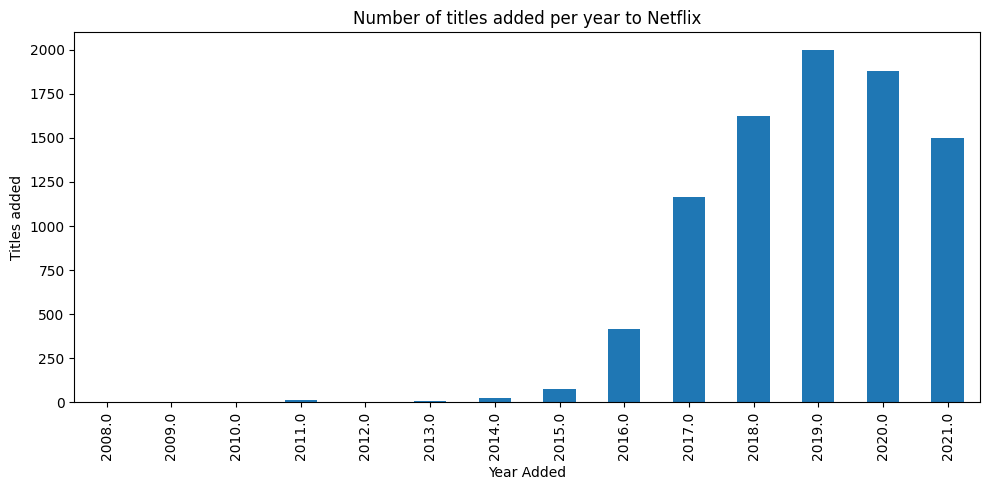

In [ ]:
# 4.1: Time series - titles added per year
plt.figure(figsize=(10,5))
df['year_added'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of titles added per year to Netflix')
plt.xlabel('Year Added')
plt.ylabel('Titles added')
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

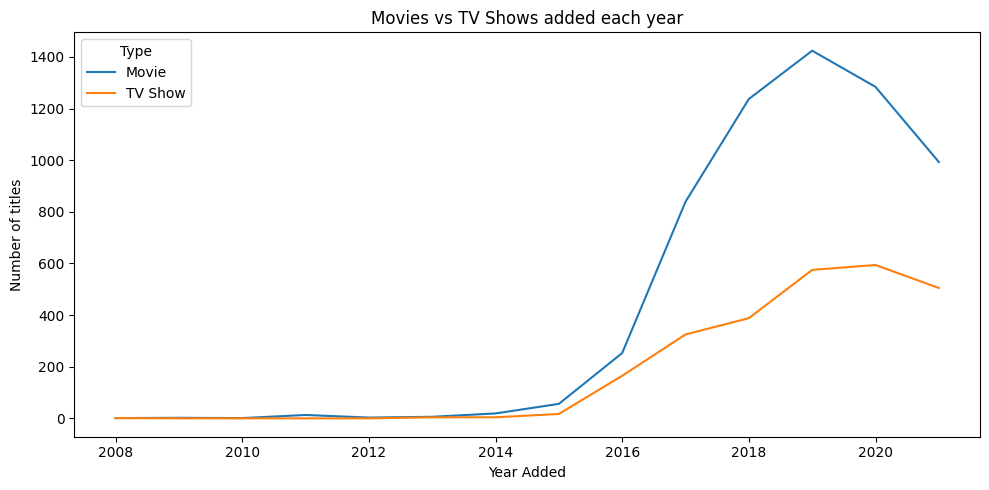

In [ ]:
# 4.2 Movies vs TV shows by year_added
plt.figure(figsize=(10,5))
pd.crosstab(df['year_added'], df['type']).fillna(0).sort_index().plot(kind='line', figsize=(10,5))
plt.title('Movies vs TV Shows added each year')
plt.xlabel('Year Added')
plt.ylabel('Number of titles')
plt.legend(title='Type')
plt.tight_layout()
plt.show()


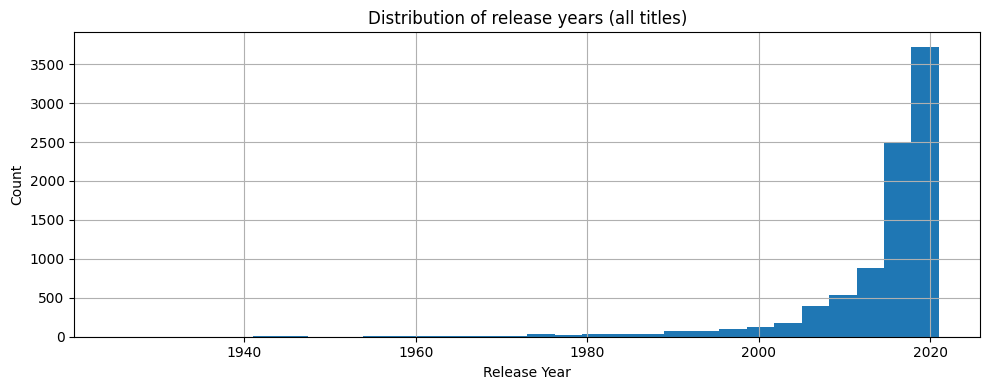

In [ ]:
# 4.3 Distribution of release_year (histogram)
plt.figure(figsize=(10,4))
df['release_year'].dropna().astype(int).hist(bins=30)
plt.title('Distribution of release years (all titles)')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


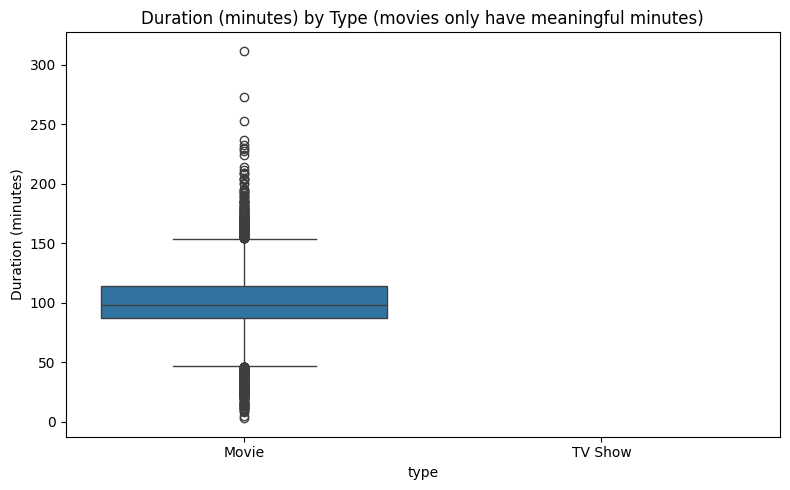

In [ ]:
# 4.4 Boxplot: duration by type (only for minutes)
plt.figure(figsize=(8,5))
sns.boxplot(x='type', y='duration_int', data=df[df['duration_type']=='minutes'])
plt.title('Duration (minutes) by Type (movies only have meaningful minutes)')
plt.ylabel('Duration (minutes)')
plt.tight_layout()
plt.show()


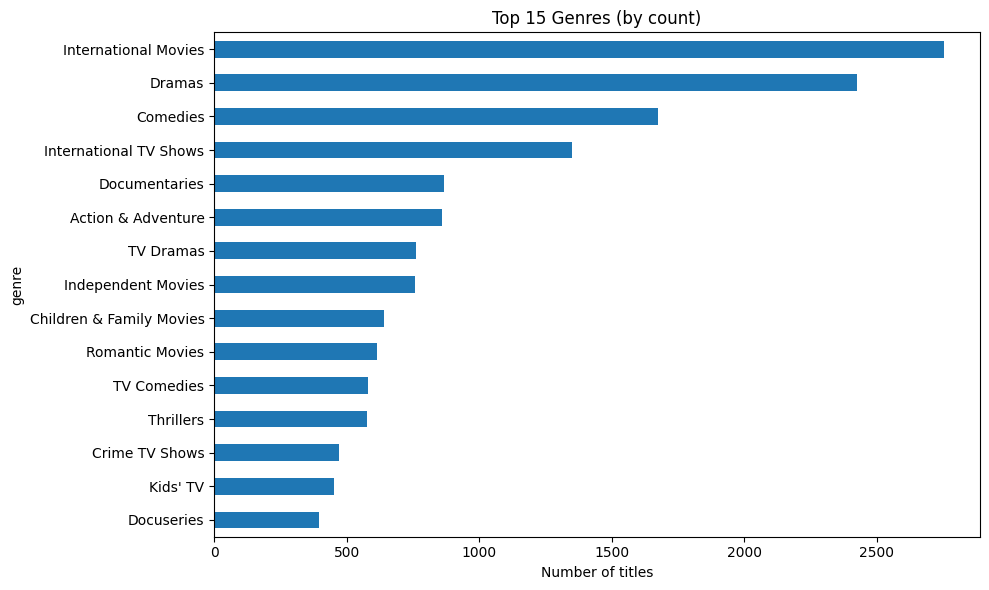

In [ ]:
# 4.5 Top genres bar chart
top_genres = df_genre_expl['genre'].value_counts().nlargest(15)
plt.figure(figsize=(10,6))
top_genres.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 15 Genres (by count)')
plt.xlabel('Number of titles')
plt.tight_layout()
plt.show()


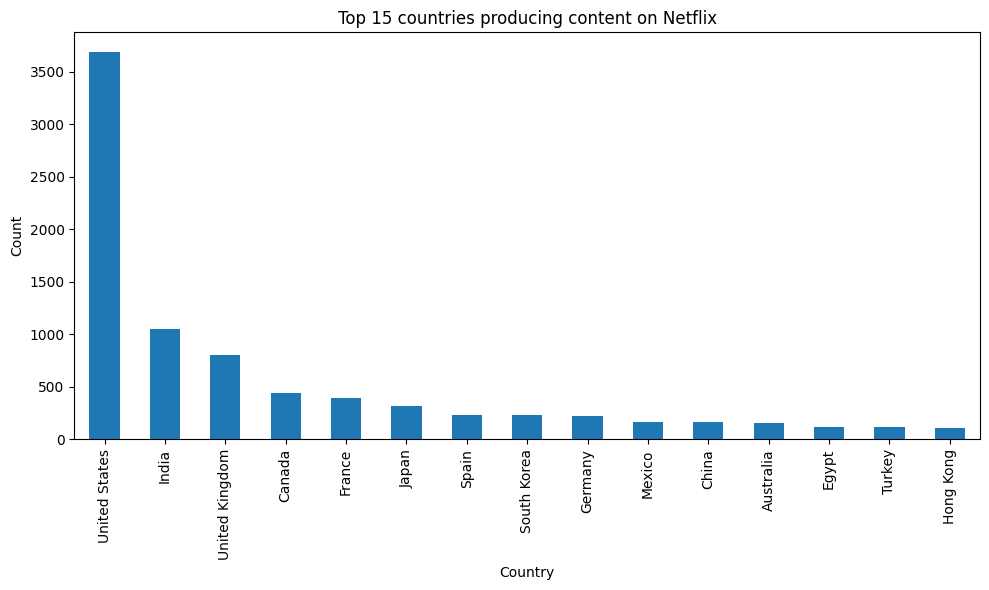

In [ ]:
# 4.6 Top countries
top_countries = df_country_expl['country_exploded'].value_counts().nlargest(15)
plt.figure(figsize=(10,6))
top_countries.plot(kind='bar')
plt.title('Top 15 countries producing content on Netflix')
plt.xlabel('Country')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

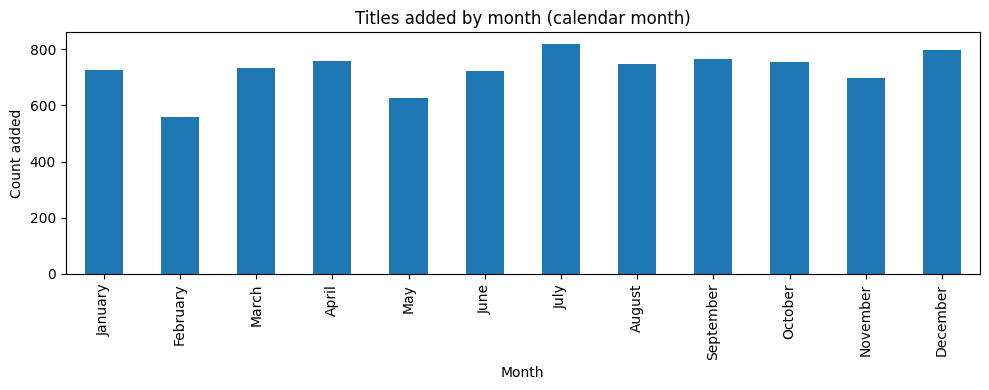

In [ ]:
# 4.7 Seasonality: month added (which month sees more additions)
plt.figure(figsize=(10,4))
df['month_name_added'].value_counts().reindex(
    ['January','February','March','April','May','June','July','August','September','October','November','December']
).plot(kind='bar')
plt.title('Titles added by month (calendar month)')
plt.xlabel('Month')
plt.ylabel('Count added')
plt.tight_layout()
plt.show()


In [ ]:
# 4.8 Top directors and actors
print("Top directors:")
print(df_dir_expl['director'].iloc[:,1].value_counts().head(10))
print("\nTop actors:")
print(df_cast_expl['actor'].value_counts().head(15))

Top directors:
director
Rajiv Chilaka          22
Jan Suter              21
Raúl Campos            19
Suhas Kadav            16
Marcus Raboy           16
Jay Karas              15
Cathy Garcia-Molina    13
Martin Scorsese        12
Youssef Chahine        12
Jay Chapman            12
Name: count, dtype: int64

Top actors:
actor
Anupam Kher         43
Shah Rukh Khan      35
Julie Tejwani       33
Takahiro Sakurai    32
Naseeruddin Shah    32
Rupa Bhimani        31
Om Puri             30
Akshay Kumar        30
Yuki Kaji           29
Amitabh Bachchan    28
Paresh Rawal        28
Boman Irani         27
Rajesh Kava         26
Vincent Tong        26
Andrea Libman       25
Name: count, dtype: int64


In [ ]:

# Missing value summary
missing = df.isna().sum().sort_values(ascending=False)
missing[missing>0]


,0
director,2634
country,831
cast,825
month_added,98
date_added,98
year_added,98
month_name_added,98
rating,4
duration_int,3
duration,3


In [ ]:
df['duration_int'].describe()


,duration_int
count,8804.0
mean,69.846888
std,50.814828
min,1.0
25%,2.0
50%,88.0
75%,106.0
max,312.0


In [ ]:
# Cell 17 - Quick textual outputs for copy/paste into report
def top_n_dict(s, n=10):
    return s.value_counts().head(n).to_dict()

print("TOTAL TITLES:", len(df))
print("TYPE DISTRIBUTION:")
print(df['type'].value_counts().to_dict())
print("\nTOP 10 GENRES:", top_n_dict(df_genre_expl['genre'], 10))
print("\nTOP 10 COUNTRIES:", top_n_dict(df_country_expl['country_exploded'], 10))
print("\nTOP 10 DIRECTORS:", top_n_dict(df_dir_expl['director'].iloc[:,1], 10))
print("\nTOP 15 ACTORS:", top_n_dict(df_cast_expl['actor'], 15))

TOTAL TITLES: 8807
TYPE DISTRIBUTION:
{'Movie': 6131, 'TV Show': 2676}

TOP 10 GENRES: {'International Movies': 2752, 'Dramas': 2427, 'Comedies': 1674, 'International TV Shows': 1351, 'Documentaries': 869, 'Action & Adventure': 859, 'TV Dramas': 763, 'Independent Movies': 756, 'Children & Family Movies': 641, 'Romantic Movies': 616}

TOP 10 COUNTRIES: {'United States': 3690, 'India': 1046, 'United Kingdom': 806, 'Canada': 445, 'France': 393, 'Japan': 318, 'Spain': 232, 'South Korea': 231, 'Germany': 226, 'Mexico': 169}

TOP 10 DIRECTORS: {'Rajiv Chilaka': 22, 'Jan Suter': 21, 'Raúl Campos': 19, 'Suhas Kadav': 16, 'Marcus Raboy': 16, 'Jay Karas': 15, 'Cathy Garcia-Molina': 13, 'Martin Scorsese': 12, 'Youssef Chahine': 12, 'Jay Chapman': 12}

TOP 15 ACTORS: {'Anupam Kher': 43, 'Shah Rukh Khan': 35, 'Julie Tejwani': 33, 'Takahiro Sakurai': 32, 'Naseeruddin Shah': 32, 'Rupa Bhimani': 31, 'Om Puri': 30, 'Akshay Kumar': 30, 'Yuki Kaji': 29, 'Amitabh Bachchan': 28, 'Paresh Rawal': 28, 'Boman 